In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
passengerID = test['PassengerId']

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train_o = train.copy()

In [7]:
data = [train, test]

In [8]:
train['Has_cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_cabin'] = test['Cabin'].apply(lambda x: 0 if type == float else 1)

In [9]:
for d in data:
    d['FamilySize'] = d['SibSp'] + d['Parch'] + 1

In [10]:
for d in data:
    d['isAlone'] = 0
    d.loc[d['FamilySize'] == 1, 'isAlone'] = 1

In [11]:
for d in data:
    d['Embarked'] = d['Embarked'].fillna('S')

In [12]:
for d in data:
    avg_age = d['Age'].mean()
    std_age = d['Age'].std()
    age_null_cnt = d['Age'].isnull().sum()
    age_null_random_list = np.random.randint(avg_age - std_age, avg_age + std_age, size = age_null_cnt)
    d.loc[np.isnan(d['Age']), 'Age'] = age_null_random_list
    d['Age'] = d['Age'].astype(int)

In [13]:
def get_titles(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [14]:
for d in data:
    d['Title'] = d['Name'].apply(get_titles)

In [15]:
for d in data:
    d['Title'] = d['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Common')
    d['Title'] = d['Title'].replace(['Mlle', 'Ms'], 'Miss')
    d['Title'] = d['Title'].replace('Mme', 'Mrs')
    

In [16]:
for d in data:
    d['Sex'] = d['Sex'].map({'female' : 0, 'male' : 1}).astype(int) 
    title_mapping = {'Mr' : 1, 'Master' : 2, 'Mrs' : 3, 'Miss' : 4, 'Common' : 5}
    d['Title'] = d['Title'].map(title_mapping)
    d['Title'] = d['Title'].fillna(0)
    d['Embarked'] = d['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2}).astype(int)
    d.loc[d['Fare'] <= 7.91, 'Fare'] = 0
    d.loc[(d['Fare'] > 7.91) & (d['Fare'] <= 14.454), 'Fare'] = 1
    d.loc[(d['Fare'] > 14.454) & (d['Fare'] <= 31), 'Fare'] = 2
    d.loc[d['Fare'] > 31, 'Fare'] = 3
    d['Fare'] = d['Fare'].fillna(-1)
    d['Fare'] = d['Fare'].astype(int)
    d.loc[d['Age'] <= 16, 'Age'] = 0
    d.loc[(d['Age'] > 16) & (d['Age'] <=32), 'Age'] = 1
    d.loc[(d['Age'] > 32) & (d['Age'] <=48), 'Age'] = 2
    d.loc[(d['Age'] > 48) & (d['Age'] <= 64), 'Age'] = 3
    d.loc[d['Age'] > 64, 'Age'] = 4

In [17]:
redundant_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(redundant_cols, axis = 1)
test = test.drop(redundant_cols, axis = 1)

In [18]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_cabin,FamilySize,isAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


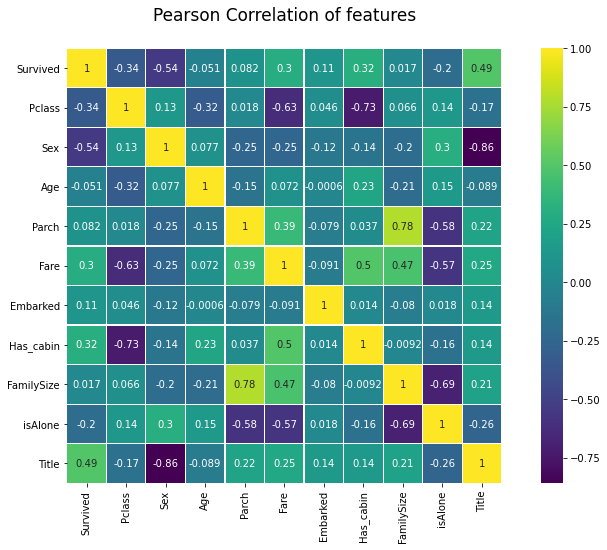

In [19]:
cmap = plt.cm.viridis
plt.figure(figsize = (14, 8))
plt.title('Pearson Correlation of features', y = 1.05, size = 17)
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = cmap, linecolor= 'white', annot= True)


In [20]:
train.corr()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_cabin,FamilySize,isAlone,Title
Survived,1.000000,-0.338481,-0.543351,-0.050996,0.081629,0.295875,0.106811,0.316912,0.016639,-0.203367,0.492031
Pclass,-0.338481,1.000000,0.131900,-0.322560,0.018443,-0.628459,0.045702,-0.725541,0.065997,0.135207,-0.165849
Sex,-0.543351,0.131900,1.000000,0.077175,-0.245489,-0.248940,-0.116569,-0.140391,-0.200988,0.303646,-0.859084
Age,-0.050996,-0.322560,0.077175,1.000000,-0.151429,0.072058,-0.000601,0.230294,-0.211431,0.147666,-0.088834
Parch,0.081629,0.018443,-0.245489,-0.151429,1.000000,0.393048,-0.078665,0.036987,0.783111,-0.583398,0.221987
Fare,0.295875,-0.628459,-0.248940,0.072058,0.393048,1.000000,-0.091096,0.497108,0.465815,-0.568942,0.252631
Embarked,0.106811,0.045702,-0.116569,-0.000601,-0.078665,-0.091096,1.000000,0.013774,-0.080281,0.017807,0.142480
Has_cabin,0.316912,-0.725541,-0.140391,0.230294,0.036987,0.497108,0.013774,1.000000,-0.009175,-0.158029,0.138106
FamilySize,0.016639,0.065997,-0.200988,-0.211431,0.783111,0.465815,-0.080281,-0.009175,1.000000,-0.690922,0.213570
isAlone,-0.203367,0.135207,0.303646,0.147666,-0.583398,-0.568942,0.017807,-0.158029,-0.690922,1.000000,-0.259345


In [21]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [22]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [23]:
title_and_sex = train_o.copy()[['Name', 'Sex']]
title_and_sex['Title'] = title_and_sex['Name'].apply(get_titles)
title_and_sex['Sex'] = title_and_sex['Sex'].map({'female' : 0, 'male' : 1}).astype(int)
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [24]:
def gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_obs_survival_prob = survival_prob
    random_obs_not_survival_prob = (1 - random_obs_survival_prob)
    mislabelled_survival_prob = not_survival_prob * random_obs_survival_prob
    mislabelled_not_survival_prob = survival_prob * random_obs_not_survival_prob
    gini =  mislabelled_not_survival_prob + mislabelled_survival_prob
    return gini

In [25]:
start_node = gini_impurity(342, 891)
start_node

0.47301295786144265

In [26]:
gini_impurity_men = gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [27]:
gini_impurity_women = gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [28]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - start_node
sex_gini_decrease

-0.13964795747285214

In [29]:
gini_impurity_title_1 = gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [30]:
gini_impurity_title_others = gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [31]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - start_node
title_gini_decrease

-0.14267004758907514

In [32]:
folds = KFold(n_splits = 10)
accuracies_for_each_fold = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

In [33]:
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    print("Current max depth", depth, "\n")
    for train_fold, valid_fold in folds.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold]
        model = tree_model.fit(X = f_train.drop(['Survived'], axis = 1), y = f_train['Survived'])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis = 1), y = f_valid['Survived'])
        fold_accuracy.append(valid_acc)
    
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies_for_each_fold.append(avg)
    print("Accuracy per fold: ", fold_accuracy, "\n")
    print("Average accuracy: ", avg)
    print("\n")

Current max depth 1 

Accuracy per fold:  [0.7666666666666667, 0.7752808988764045, 0.7528089887640449, 0.8539325842696629, 0.7640449438202247, 0.8089887640449438, 0.7528089887640449, 0.7528089887640449, 0.8426966292134831, 0.7528089887640449] 

Average accuracy:  0.7822846441947565


Current max depth 2 

Accuracy per fold:  [0.7222222222222222, 0.8202247191011236, 0.7640449438202247, 0.8426966292134831, 0.797752808988764, 0.8314606741573034, 0.797752808988764, 0.7640449438202247, 0.8539325842696629, 0.797752808988764] 

Average accuracy:  0.7991885143570537


Current max depth 3 

Accuracy per fold:  [0.8333333333333334, 0.8764044943820225, 0.7640449438202247, 0.8651685393258427, 0.8202247191011236, 0.8202247191011236, 0.7865168539325843, 0.7865168539325843, 0.8764044943820225, 0.8539325842696629] 

Average accuracy:  0.8282771535580522


Current max depth 4 

Accuracy per fold:  [0.8333333333333334, 0.8089887640449438, 0.7865168539325843, 0.797752808988764, 0.8202247191011236, 0.8314

In [34]:
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies_for_each_fold})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.815955
         6          0.808140
         7          0.809226
         8          0.810412
         9          0.814894
        10          0.809288


In [35]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis = 1)
x_test = test.values

In [36]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
y_pred = decision_tree.predict(x_test)
results = pd.DataFrame({
        "PassengerId": passengerID ,
        "Survived": y_pred
    })
results.to_csv('titanic_decision_tree_results.csv', index=False)

In [38]:
with open("titanic_tree_1.dot", "w") as f:
    f = tree.export_graphviz(decision_tree, out_file = f, max_depth=3, impurity= True, feature_names= list(train.drop(['Survived'], axis= 1)), class_names= ['Died', 'Survived'], rounded= True, filled = True)

In [39]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38